# Neural Systems Example Project: Three Perfect Squares Illusion 
This illusion was implemented using the [Matplotlib plotting library](http://matplotlib.org/), and uses the [ipython widgets](http://ipywidgets.readthedocs.io/en/latest/index.html) package to make the illusion interactive. For an introduction on drawing shapes with matplotlib, see [this tutorial](http://matthiaseisen.com/matplotlib/shapes/). You are free to use any alternative/additional packages to program your illusion, but must keep to the general project requirements and submission instructions, outlined on the course Moodle. 

In [1]:
# Import packages 
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.ticker import NullLocator
%matplotlib inline
import numpy as np 
import os 
from os import listdir
from os.path import isfile, join
from scipy import ndimage
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
import matplotlib.image as mpimg
from PIL import Image

## Create ipython widgets to let the user interact with the illusion
The [IPython widgets](http://ipywidgets.readthedocs.io/en/latest/index.html) package provides functionality to create widgets to interact with matplotlib plots. We define a slider widget for the distortion, and use Text and Button widgets to define a form for collecting user data. The ToggleButtons widget allows the user to toggle between different variations of the illusion, which we specify in the variable "illusion_variation_dict". 
 * [Tutorial](https://jakevdp.github.io/blog/2013/12/05/static-interactive-widgets/ ) on programming ipython widgets
 *  [List of available widgets](http://ipywidgets.readthedocs.io/en/latest/examples/Widget%20List.html)

In [2]:
from ipywidgets import FloatSlider, RadioButtons, Text, Button, HBox, VBox, interactive, HTML, ToggleButtons, ToggleButton, Layout
from IPython.display import display

## Illusion parameters (default values) 
# Image scale of the illusion 
default_image_scale = 7
# density of the lines in the square pattern
default_density = 4 
# the line width of the purple square
default_purple_width = 2 
# Distortion we will apply to the purple squares 
default_distort = 0. 
# line width of the black lines in the pattern  
default_pattern_linewidth = 1.8 
# Hatch sets the hatching pattern in a Matplotlib patch. hatch can be one of: 
# [‘/’ | ‘\’ | ‘|’ | ‘-‘ | ‘+’ | ‘x’ | ‘o’ | ‘O’ | ‘.’ | ‘*’]
# Which fills a matplotlib patch with a different pattern. 
default_hatch_1 = "/"
# 
default_hatch_2 = "\\"
# The distance between all outer and inner squares. This is a relative value. 
dist = 1. 
# The width of a single square. 
pattern_square_width = dist * 8 - dist
# Folder where images are stored 
images_folder = "img"
pattern_folder = "background"
if not os.path.exists(images_folder):
    os.makedirs(images_folder)
if not os.path.exists(pattern_folder):
    os.makedirs(pattern_folder)
    
# If true, will keep redrawing pattern every time a user interacts with the illusion 
force_replot = False 

default_parameters = {
    "image_scale": default_image_scale, 
    "density": default_density, 
    "purple_width": default_purple_width, 
    "pattern_linewidth": default_pattern_linewidth, 
    "hatch_1": default_hatch_1, 
    "hatch_2": default_hatch_2, 
    "pattern_angle": None, # Apply a rotation to the lines in the background pattern. 
    "originalID": None # Represents the actual ID of our illusion. 
}

## This variable specifies the parameter variations we will apply 
illusion_variations = {
    1: {"originalID": 1}, 
    2: {"hatch_1": "\\", "hatch_2": "/", "originalID": 2}, 
    3: {"density": 2, "originalID": 3}, 
    4: {"hatch_1": "|", "hatch_2": "-", "originalID": 4}    
}

# Angle variations we will look at: from 10 to 80 degrees 
angles = range(10, 90, 10)
remaining_indices = range(max(illusion_variations.keys()) + 1, len(angles) + max(illusion_variations.keys()) + 1)
for i, ang in zip(remaining_indices, angles): 
    illusion_variations[i] = {"pattern_angle": ang, "originalID": i}
    
llusion_count = len(illusion_variations)
## This dictionary contains the final illusion parameters for each illusion variation we will 
# display to the subject. 
illusion_variation_dict = {}
illusions_to_modify = list(illusion_variations.keys())

# Create a dictionary with default parameters
for i in illusions_to_modify: 
    illusion_variation_dict[i] = default_parameters.copy()

def add_variation(param_dict): 
    # Randomize order of illusions 
    # Pick a random number, and change the illusion parameters to get different illusion variations 
    num = np.random.choice(illusions_to_modify, replace=False)
    illusions_to_modify.remove(num)
    for key, value in param_dict.items(): 
        illusion_variation_dict[num][key] = value

# Modify the parameters according to our illusion variations 
for variation in illusion_variations.values(): 
    add_variation(variation)

# Make sure number of illusions adds up
assert not illusions_to_modify

## Create some sliders and buttons 
distort_slider = FloatSlider(min=-0.1, max=0.1, step=0.001, value=default_distort, 
                             description="Distort:",  readout=False, continuous_update=True)

selector = ToggleButtons(
    options=list(illusion_variation_dict.keys()),
    description='Variation:',
    disabled=False,
    button_style='', 
    value=2
)

def reset_distort(button): 
    # randomize slider min, max and starting value for every illusion switch 
    # (to avoid the subject remembering the values from previously completed illusion variations)
    distort_slider.min = np.random.uniform(-0.15, -0.05)
    distort_slider.max = np.random.uniform(0.05, 0.15)
    distort_slider.value = np.random.uniform(distort_slider.min, distort_slider.max) 
    
selector.observe(reset_distort, "value")

## Widgets for the input form 
# Username text box 
user_name = Text(
    value='',
    placeholder='Please enter your ETH username.',
    description='Name:',
    disabled=False
)
checkbox = RadioButtons(
    options={'No':2, 'Yes':3},
    description='Do the squares appear straight?',
    value=2
)

# Submit button 
submit_button = ToggleButton(
    description='Submit data',
    disabled=False,
    button_style='',
    tooltip='Submit data',
    icon='check'
)

input_widgets = [user_name, checkbox, submit_button]

## Functions to draw the elements of the simulation with matplotlib
We define functions that draw the striped background pattern and purple squares. 

 * [Drawing squares](http://matplotlib.org/api/patches_api.html#matplotlib.patches.Rectangle)
 * [Drawing polygons](http://matplotlib.org/api/patches_api.html#matplotlib.patches.Polygon)

In [ ]:
## Simple implementation of the background pattern. 

def get_patches(x, y, dist, hatch_size, hatch_1="/", hatch_2="\\"): 
    """Draw a single background square, that itself consists of 3 individual squares, filled with lines. 
    
    :param x: x location to place the square
    :param y: y location to place the square 
    :param dist: 
    :param hatch_size: density of the lines in the pattern 
    :param hatch_1: orientation of the lines in the outer most square in the pattern. 
    This is a feature of matplotlib, "\\" will draw lines from top left to bottom right, 
    while "/" will draw them from top right to bottom left. 
    :param hatch_2: 
    :return: an array of patches 
    """
    patches_arr = [] 
    curr_hatch = hatch_size * hatch_1
    sizes = np.arange(dist, dist*8, dist*2)[::-1]
    for current_size in sizes: 
        # Generate a square at the desired location (x, y) with size current_size. Fill it with line pattern. 
        p = patches.Rectangle(
                (x, y), current_size, current_size,
                hatch=curr_hatch, 
                fill=True, 
                facecolor="white", 
                edgecolor='black', 
                lw=0, 
                zorder=0
            )
        patches_arr.append(p)
        x += dist 
        y += dist 
        if curr_hatch[0] == hatch_1: 
            curr_hatch = hatch_size * hatch_2
        else: 
            curr_hatch = hatch_size * hatch_1
    return patches_arr

In [3]:
from itertools import islice

def window(seq, n=2):
    "Returns a sliding window (of width n) over data from the iterable"
    "   s -> (s0,s1,...s[n-1]), (s1,s2,...,sn), ...                   "
    it = iter(seq)
    result = tuple(islice(it, n))
    if len(result) == n:
        yield result    
    for elem in it:
        result = result[1:] + (elem,)
        yield result

In [4]:
## More complex implementation of the pattern. 
# Allows to specify the angle of the black lines.

def plot_hatches(filename, angle, offset=.05, linewidth=4, figsize=(2.4, 2.4), dpi=150):
    """"Generate striped pattern, and save as .png. 
    
    :param filename: the filename to save the pattern to
    :param angle: the angle of the lines 
    :param offset: the distance between the lines
    :param linewidth: the width of the liens 
    :param figsize: the size of the saved image
    :param dpi: the dpi of the image"""
    fig = plt.figure(figsize=figsize, dpi=dpi, frameon=False)
    ax = fig.add_axes([0, 0, 1, 1])
    ax.axis('off')
    ## Generate lines at an angle 
    angle_radians = np.radians(angle)
    x = np.linspace(-2, 2, 10)
    for c in np.arange(-2, 2, offset):
        yprime = np.cos(angle_radians) * c + np.sin(angle_radians) * x
        xprime = np.sin(angle_radians) * c - np.cos(angle_radians) * x
        ax.plot(xprime, yprime, color="black", linewidth=linewidth)
        
    # Remove as much whitespace around plot as possible. 
    ax.set_ylim(0., 1.)
    ax.set_xlim(0., 1.)
    a=fig.gca()
    a.set_frame_on(False)
    a.set_xticks([])
    a.set_yticks([])
    plt.axis('off')
    ax.axis('off')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    plt.savefig(filename, bbox_inches="tight", pad_inches=0)
    plt.clf()
    plt.close()

In [5]:
def plot_pattern(angle, size=pattern_square_width, offsets=[0.03, 0.05, 0.08, 0.21], linewidth=8., linewidth_step=1., dpi=100, force_replot=force_replot):
    """Combine striped patterns to get our illusion background
    
    :param angle: the angle of the lines 
    :param size: the size of the figure
    :param offsets: the space between the lines for each pattern (manually determined, depend on the image scale)
    :param linewidth: the thickness of the line 
    :param linewidth_step: increase the line thickness by this amount for every smaller pattern
    :param dpi: the dpi of the output image
    :param force_replot: if true, will redraw the pattern every time, otherwise load from disc 
    
    :return: list of filenames that contain the patterns"""
    size_step = size / 4
    filenames = []
    angle_1 = angle 
    angle_2 = 90 + angle 
    for i in range(1,5):
        filename = "{}/hatch_background_{}_{}.png".format(pattern_folder, i, angle)
        if not os.path.isfile(filename) or force_replot: # If already generated this angle 
            plot_hatches(filename, angle, offset=offsets[i-1], linewidth=linewidth, figsize=(size, size), dpi=dpi)    
        linewidth += linewidth_step
        # Decrease size of figure
        size -= size_step
        # Alternate the angle 
        angle = angle_1 if angle != angle_1 else angle_2 
        filenames.append(filename)
    return filenames

In [6]:
## Generate the images of the background pattern in advance, to save computation  
for d in illusion_variation_dict.values(): 
    angle = d["pattern_angle"]
    if angle is not None: 
        plot_pattern(angle)
        plot_pattern(-angle)

In [7]:
def distance(a, b): 
    return np.sqrt(np.square(a[1] - a[0]) + np.square(b[1] - b[0]))

In [8]:
def get_distorted_square(start_location, size, line_width=1., distort=0., print_degrees=False, 
                         reverse_distort=False): 
    """Draw a single distorted purple square. 
    
    :param start_location: the distance from the origin of the purple square
    :param size: the size of the square
    :param line_width: width of the square
    :param distort: amount of distortion to be applied to the square
    :param reverse_distort: if true, distort in the opposite direction (e.g. the middle square)
    :return: a Polygon patch that contains the square 
    """
    orig_square_size = distance([start_location, start_location], [start_location, start_location + size])
    # print "Square size: {}".format(orig_square_size)
    
    # Determine the points of the square 
    if reverse_distort: 
        bottom_left_location = [start_location + distort, start_location + distort]
        bottom_right_location = [start_location, start_location + size]
        top_right_location = [start_location + size - distort, start_location + size - distort]
        top_left_location = [start_location + size, start_location]
    else: 
        bottom_left_location = [start_location, start_location]
        bottom_right_location = [start_location + distort, start_location + size - distort]
        top_right_location = [start_location + size, start_location + size]
        top_left_location = [start_location + size - distort, start_location + distort]

    ## Draw a polygon. 
    # Essentially the way this works is you choose four points (x, y), and matplotlib conntects and fills them 
    polygon = patches.Polygon([bottom_left_location, bottom_right_location, 
                            top_right_location, top_left_location], 
                            closed=True, fill=False, 
                            linewidth=str(line_width),
                            edgecolor="purple", 
                              zorder=1)
    
    if print_degrees: 
        # Calculate the angle of the rhombus after applying the distortion
        diagonal1 = distance(top_left_location, bottom_right_location)
        diagonal2 = orig_square_size * np.sqrt(2)
        side = np.sqrt(np.square(diagonal1) + np.square(diagonal2))/2
        area = (diagonal1 * diagonal2) / 2 
        sine_a = area / np.square(side) 
        rhombus_angle = np.degrees(np.arcsin(sine_a))
        # Uncomment to see the angle of the squares
        # print("Rhombus angle: {}".format(rhombus_angle))
        return polygon, rhombus_angle
    else: 
        return polygon
    

## Assemble all the above components
We use the functions to first draw the pattern, and then the three purple squares. 

In [9]:
def draw_squares(illusion_selector=0, distort=default_distort, save_figure=False): 
    """This is the main function, that plots the illusion. 
    
    :param illusion_selector: runs the illusion with a predefined parameter set 
    :param distort: distort the purple squares 
    :param save_figure: if true, will save a .png of the illusion on disk with 
    the statistics of the illusion. 
    :return: 
    """
    # Load the parameters for the selected illusion 
    params_dict = illusion_variation_dict[illusion_selector]    
    img_scale = params_dict["image_scale"]
    pattern_linewidth = params_dict["pattern_linewidth"]
    density = params_dict["density"]
    purple_width = params_dict["purple_width"]
    hatch_1 = params_dict["hatch_1"]
    hatch_2 = params_dict["hatch_2"]
    pattern_angle = params_dict["pattern_angle"]
    originalID = params_dict["originalID"]

    ### Draw the nine background squares 
    # The width of the line of the pattern. This is a parameter of Matplotlib. 
    matplotlib.rcParams['hatch.linewidth'] = pattern_linewidth
    # Container for all the elements to be drawn 
    patches_arr = []
    sizes = np.arange(0., pattern_square_width * 3, pattern_square_width)
    h1 = hatch_1
    h2 = hatch_2
        
    if pattern_angle is None: # If we don't need an angle applied to the background pattern
        # Draw the 3x3 pattern: simple version 
        for size_1 in sizes: 
            for size_2 in sizes: 
                patches_arr += get_patches(size_1, size_2, dist, density, hatch_1=h1, hatch_2=h2)
                if h1 == hatch_2:                
                    h1 = hatch_1
                    h2 = hatch_2
                else: 
                    h1 = hatch_2
                    h2 = hatch_1
                
    ### Draw the three purple squares
    # The location of the purple square
    purple_loc = pattern_square_width + dist / 2
    # the size of the square 
    current_size = pattern_square_width - dist
    # Uncomment to see the value of the distortion
#     print("Distort input: {}".format(distort))
    purple_patches = []
    for i in range(3): 
        # Make distortion proportional to the size of the square 
        distort_ = distort * current_size
        # print "Distort value for square {}: {}".format(i + 1, distort_)
        if i == 0: 
            square, rhombus_degrees = get_distorted_square(purple_loc, current_size, purple_width,distort_, 
                                            print_degrees=True, reverse_distort=False)
            purple_patches.append(square)
        elif i == 1: # Distort middle square in the opposite direction 
            purple_patches.append(get_distorted_square(purple_loc, current_size, purple_width,distort_, 
                                            print_degrees=False, reverse_distort=True))
        else: 
            purple_patches.append(get_distorted_square(purple_loc, current_size, purple_width,distort_, 
                                            reverse_distort=False))
        # Update location and size for the next square to be drawn 
        purple_loc += dist
        current_size -= dist * 2 
    
    ### Render final figure 
    fig = plt.figure(figsize=(img_scale,img_scale), dpi=100)
    ax = fig.add_subplot(111,  aspect='equal')
    
    if pattern_angle is None : 
        for p in patches_arr:
            # add_patch adds a patch to the current figure 
            ax.add_patch(p)
            
    else: 
        ## Draw the 3x3 background pattern: more complicated version         
        def display_single_pattern(size_1, size_2, hatches): 
            """Plot a single square of the pattern
            
            :param size_1, size_2: starting coordinates of this plot"""
            a, b, c, d = size_1[0], size_1[1], size_2[0], size_2[1]
            for i in range(4): 
                img = Image.open(hatches[i])
                width, height = img.size
                # Crop the image with PIL library, because Matplotlib adds a little white border
                img = img.crop((3, 3, width - 3, height - 3))
                plt.imshow(img, interpolation="none", aspect="equal", extent=(a, b, c, d), origin='upper')
                a += dist
                b -= dist 
                c += dist
                d -= dist
        
        # Get the list of patterns (redraw or from disk)
        hatches_1 = plot_pattern(pattern_angle)
        hatches_2 = plot_pattern(-pattern_angle)
        
        sizes = np.arange(0., pattern_square_width * 4, pattern_square_width)
        reverse = True # A switch for the angle 
        for size_1 in window(sizes): 
            for size_2 in window(sizes): 
                if reverse: 
                    display_single_pattern(size_1, size_2, hatches_2)
                else: 
                    display_single_pattern(size_1, size_2, hatches_1)
                reverse = not reverse
                
    # Display purple squares     
    for p in purple_patches: 
        ax.add_patch(p)

    total_figure_size = pattern_square_width * 3
    # Add a red cross in the center of the image 
    plt.scatter([total_figure_size / 2],[total_figure_size / 2],color='#a10000', 
                marker="+",s=150, lw=2, zorder=1)
    
    # Clean extra whitespace around the plot and remove axes 
    axes = plt.gca()
    axes.set_xlim([0.,total_figure_size])
    axes.set_ylim([0.,total_figure_size])
    plt.axis('off')
    axes.xaxis.set_major_locator(NullLocator())
    axes.yaxis.set_major_locator(NullLocator())     
        
    ### For submitting data 
    if save_figure:
        # Submit button is pressed
        # Check if the user entered his info 
        if user_name.value.strip() == '':
            submit_button.button_style = "danger"
            submit_button.description = "Please enter username!"
        else: 
            submit_button.button_style = ""
            submit_button.description = "Submitted. Again?"
            values_to_save = {
                "originalID": originalID, 
                "distort": distort,
                "degrees": str(rhombus_degrees)[:5], 
                "user":user_name.value, 
                "annihilated": "true" if checkbox.value == 3 else "false",
                "scale": img_scale, 
                "density": density, 
                "purplewidth": purple_width, 
                "hatch": "normal" if hatch_1 == "/" else "reversed" if hatch_1 == "\\" else hatch_1, 
                "patternangle": 45 if pattern_angle is None else pattern_angle
            }
            filename = ""
            # Format the filename with the illusion parameters. 
            for key, value in values_to_save.items(): 
                filename += "{}={}_".format(key, value)
            # make sure you have an 'img' folder if you're running this locally
            fig.savefig('{}/3_squares__{}.png'.format(images_folder, filename), bbox_inches='tight', pad_inches=0)     

    submit_button.value = False 

## Display the illusion and activate the sliders
The "interactive" function allows the illusion to be re-rendered as the values of the slides change. 

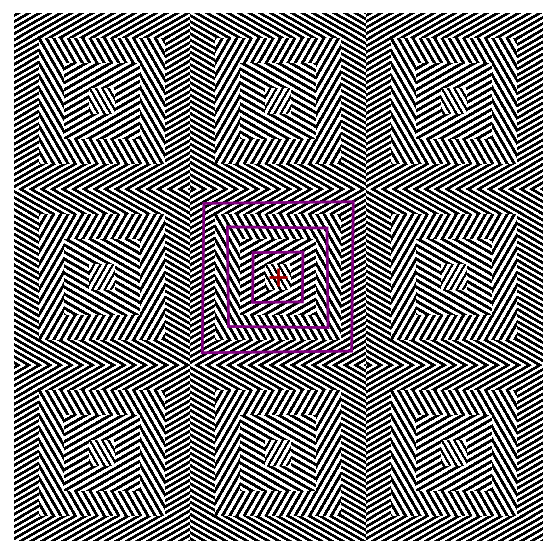

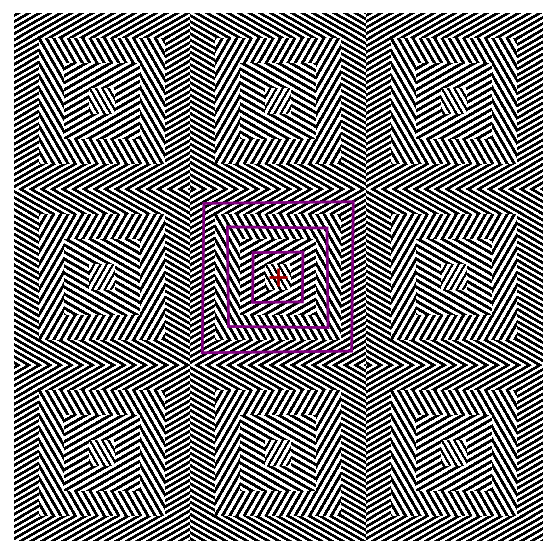

In [10]:
# User instructions
display(HTML(
    value="<h2>Three Perfect Squares Illusion</h2><p>" +
        "Focus your attention on <b style=\"color:red\">the red cross</b> in the centre of this image. "+
    "Your task is to change the distort slider until all the "+
        " polygons appear square (you can also use the arrow keys). When they look square, fill out the form and " + 
    "press the \"Submit data\" button on the right. Complete this task for each of the variations of this illusion listed below. </p>"
))
# Make the draw function interactive (will re-render the illusion on slider change)
widget = interactive(draw_squares, illusion_selector=selector, 
                     distort=distort_slider, save_figure=submit_button, __manual=False)

# Arrange sliders side by side 
box = HBox([VBox([VBox(), VBox(widget.children[:-1], width="40%")]), VBox([HTML(value="<h4>Submission form:</h4>")] + input_widgets)])
display(box) 
selector.value = 1